In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt 

import src.helper as h
from  src.plots import plot_cifar_dist, plot_cifar_img, plot_interval 
from scipy.stats import entropy, wasserstein_distance
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import train_test_split

# Simplex

In [17]:
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
samples = []
for i in np.arange(0,200, 2):
    dist = tfd.Dirichlet([20/(i+1)]*10)
    samples.append(dist.sample(1000))
simplex = np.vstack(samples)

In [18]:
simplex.shape

(100000, 10)

In [18]:
#alternatives
# samples = []
# for i in range(100):
#     dist = tfd.Dirichlet([10/(i+1)]*10)
#     samples.append(dist.sample(1000))
# samples = []
# for i in np.arange(1.0,21, 1):
#     dist1 = tfd.Dirichlet([i]*10)
#     dist2 = tfd.Dirichlet([1/i]*10)
#     samples.append(dist1.sample(10000))
#     samples.append(dist2.sample(10000))

(0.0, 1.0)

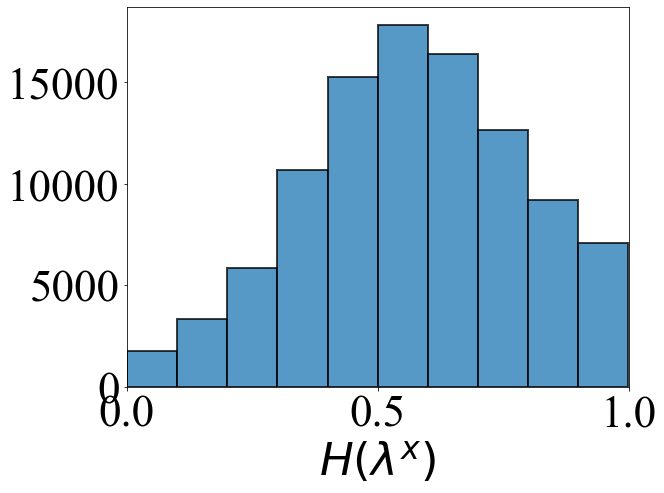

In [19]:
fig = plt.figure(figsize=(9,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
plt.hist(entropy(simplex, axis=1, base=10), alpha=.75, edgecolor='k', linewidth=2)
plt.xlabel(r'$H(\lambda^x)$')
# plt.title("GT distributions")
plt.xlim([0,1])

# Load the annotations and plot the entropies of the GT distrinutions 

In [85]:
annotations = np.load("data\cifar10h-counts.npy")
annotations_prob = annotations/annotations.sum(axis=1)[:,None]

(0.0, 1.0)

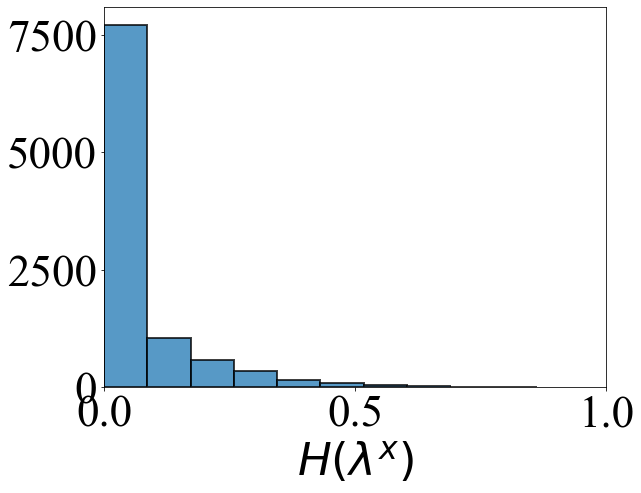

In [86]:
fig = plt.figure(figsize=(9,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
plt.hist(entropy(annotations_prob, axis=1, base=10), alpha=.75, edgecolor='k', linewidth=2)
plt.xlabel(r'$H(\lambda^x)$')
# plt.title("GT distributions")
plt.xlim([0,1])
# os.makedirs(os.path.join("figures", "cifar10h", "general"), exist_ok=True)  
# plt.savefig(os.path.join("figures", "cifar10h", "general", "histogram.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

# Import CIFAR10  

In [87]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# torch.manual_seed(0)

# Define the transformation for preprocessing the test images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])
])

# Load the CIFAR-10 test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:07<00:00, 22557732.33it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


Bringing a pretrained model on CIFAR10 train, apply it on CIFAR10 test and consider it as first-order predictor output

In [90]:
import cifar10_models.vgg as vgg

my_model = vgg.vgg11_bn()

# Pretrained model
my_model = vgg.vgg11_bn(pretrained=True)
my_model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [91]:
# Lists to store ground truth labels, predicted labels, images, and predicted distributions
true_labels = []
predicted_labels = []
images = []
predicted_distributions = []
outputs_nosoft = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        outputs = my_model(batch_images)
        outputs_nosoft.extend(outputs.tolist())
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(batch_labels.tolist())
        predicted_labels.extend(predicted.tolist())
        images.extend(batch_images)
        predicted_probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_distributions.extend(predicted_probabilities.tolist())

# Convert the images from tensors to numpy arrays
images = [image.permute(1, 2, 0).numpy() for image in images]

In [92]:
images = np.array(images)
outputs_nosoft = np.array(outputs_nosoft)
predicted_distributions = np.array(predicted_distributions)

# Now we have predictions, images, and true distributions, we can construct credal sets

Method1: No training, Use all data for calibration and test

we cannot have a second-order predictor

In [11]:
exp_seed_str = "0"
exp_seed = 0
images_calib, images_test, lambda_calib, lambda_test, lambda_hat_calib, lambda_hat_test = train_test_split(images, annotations_prob, predicted_distributions, test_size=1000, random_state=2024+exp_seed)

(0.0, 1.0)

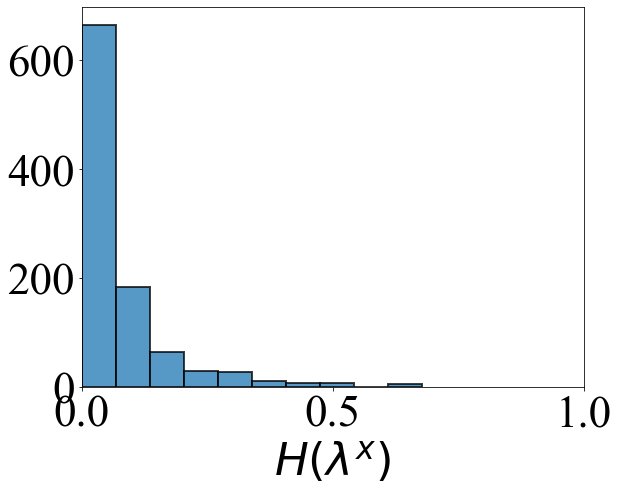

In [53]:
fig = plt.figure(figsize=(9,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
plt.hist(entropy(lambda_test, axis=1, base=10), alpha=.75, edgecolor='k', linewidth=2)
plt.xlabel(r'$H(\lambda^x)$')
# plt.title("GT distributions")
plt.xlim([0,1])

Method2: Use a portion of daata to train our predictors

In [9]:
with open(os.path.join("data", "cifar10h", "cifar10h_full.pkl"), 'rb') as f:
    cifar10h_full = pickle.load(f)

X = cifar10h_full["X"]
lambdas = cifar10h_full["lambda"]
images = cifar10h_full["images"]

In [19]:
sum(lambdas==outputs_nosoft)

array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000])

In [50]:
import sys
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import entropy, wasserstein_distance
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
tfd = tfp.distributions

import src.helper as h
from src.model import dirichlet_nll_loss_with_regularization, predictor

exp_seed_str = "0"
exp_seed = int(exp_seed_str)
predictor_order = "first"



model = predictor(order=predictor_order, feature_dim=10, n_classes=10)
if predictor_order == "first": 
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
else: 
    loss_fn = dirichlet_nll_loss_with_regularization
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn)
X_train, X_test, images_train, images_test, lambda_train, lambda_test = train_test_split(outputs_nosoft, images, annotations_prob, test_size=1000, random_state=2024+exp_seed)
X_proper_train, X_calib, images_proper_train, images_calib, lambda_proper_train, lambda_calib= train_test_split(X_train, images_train, lambda_train, test_size=8000, random_state=2024+exp_seed)
model.fit(X_proper_train, lambda_proper_train, epochs=10, batch_size=8)

Epoch 1/10
125/125 [==============================] - 1s 896us/step - loss: 2.0150
Epoch 2/10
125/125 [==============================] - 0s 805us/step - loss: 1.4675
Epoch 3/10
125/125 [==============================] - 0s 888us/step - loss: 1.1885
Epoch 4/10
125/125 [==============================] - 0s 921us/step - loss: 1.0454
Epoch 5/10
125/125 [==============================] - 0s 904us/step - loss: 0.8924
Epoch 6/10
125/125 [==============================] - 0s 904us/step - loss: 0.8652
Epoch 7/10
125/125 [==============================] - 0s 912us/step - loss: 0.8616
Epoch 8/10
125/125 [==============================] - 0s 896us/step - loss: 0.7888
Epoch 9/10
125/125 [==============================] - 0s 912us/step - loss: 0.7945
Epoch 10/10
125/125 [==============================] - 0s 848us/step - loss: 0.7500


In [52]:
lambda_hat_calib = model.predict(X_calib)
lambda_hat_test = model.predict(X_test)

32/32 [==============================] - 0s 790us/step


In [78]:
exp_seed_str = "0"
exp_seed = int(exp_seed_str)
predictor_order = "second"



model = predictor(order=predictor_order, feature_dim=10, n_classes=10)
if predictor_order == "first": 
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
else: 
    loss_fn = dirichlet_nll_loss_with_regularization
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn)
X_train, X_test, images_train, images_test, lambda_train, lambda_test = train_test_split(outputs_nosoft, images, annotations_prob, test_size=1000, random_state=2024+exp_seed)
X_proper_train, X_calib, images_proper_train, images_calib, lambda_proper_train, lambda_calib= train_test_split(X_train, images_train, lambda_train, test_size=8000, random_state=2024+exp_seed)
model.fit(X_proper_train, lambda_proper_train, epochs=10, batch_size=8)

Epoch 1/10
125/125 [==============================] - 1s 974us/step - loss: -5.7192
Epoch 2/10
125/125 [==============================] - 0s 840us/step - loss: -12.2466
Epoch 3/10
125/125 [==============================] - 0s 989us/step - loss: -12.7068
Epoch 4/10
125/125 [==============================] - 0s 808us/step - loss: -12.7714
Epoch 5/10
125/125 [==============================] - 0s 929us/step - loss: -12.7987
Epoch 6/10
125/125 [==============================] - 0s 993us/step - loss: -12.8069
Epoch 7/10
125/125 [==============================] - 0s 848us/step - loss: -12.8174
Epoch 8/10
125/125 [==============================] - 0s 986us/step - loss: -12.8240
Epoch 9/10
125/125 [==============================] - 0s 864us/step - loss: -12.8422
Epoch 10/10
125/125 [==============================] - 0s 912us/step - loss: -12.8534


In [87]:
alpha_calib = model.predict(X_calib) + 1 
alpha_test = model.predict(X_test) + 1
mode_calib = (alpha_calib-1)/np.sum(alpha_calib-1, axis=1)[:,None]
mode_test = (alpha_test-1)/np.sum(alpha_test-1, axis=1)[:,None]
dist_lambda_hat_calib = tfd.Dirichlet(alpha_calib)
dist_pred_test = tfd.Dirichlet(alpha_test)

32/32 [==============================] - 0s 724us/step


C:\Users\Alireza\AppData\Local\Temp\ipykernel_21656\23329088.py:3: RuntimeWarning: invalid value encountered in divide
  mode_calib = (alpha_calib-1)/np.sum(alpha_calib-1, axis=1)[:,None]
C:\Users\Alireza\AppData\Local\Temp\ipykernel_21656\23329088.py:4: RuntimeWarning: invalid value encountered in divide
  mode_test = (alpha_test-1)/np.sum(alpha_test-1, axis=1)[:,None]


## Calibration

In [12]:
n_classes = annotations.shape[1]
distance_functions = ["tv", "kl", "ws", "inner"]
calib_scores = {k: [] for k in distance_functions}
for i in range(len(lambda_hat_calib)):
    calib_scores["tv"].append(h.tv(lambda_hat_calib[i], lambda_calib[i]))
    calib_scores["kl"].append(entropy(lambda_calib[i], lambda_hat_calib[i], base=2))
    calib_scores["ws"].append(wasserstein_distance(np.arange(n_classes), np.arange(n_classes), lambda_hat_calib[i], lambda_calib[i]))
    calib_scores["inner"].append(1-np.inner(lambda_hat_calib[i], lambda_calib[i]))

Define adaptive scores as well for first-order methods

In [13]:
hyper = 0.1
methods = list(calib_scores.keys())
for m in methods:
    calib_scores[m+"_adaptive"] = calib_scores[m]/(entropy(lambda_hat_calib, base=10, axis=1)+ hyper)

Define SO scores [in case second-orde predictor is trained]

In [82]:
calib_scores_so = []
for k in range(X_calib.shape[0]):
    mode_p = dist_lambda_hat_calib[k].prob(mode_calib[k]).numpy()
    p = dist_lambda_hat_calib[k].prob(lambda_calib[k]).numpy()
    calib_scores_so.append(1-p/mode_p)

In [83]:
calib_scores["so"] = calib_scores_so

In [14]:
calib_scores.keys()

dict_keys(['tv', 'kl', 'ws', 'inner', 'tv_adaptive', 'kl_adaptive', 'ws_adaptive', 'inner_adaptive'])

# Some analysis on the results

In [15]:
alpha = 0.2
q = {}
for d in calib_scores.keys():
    q[d] = h.compute_quantile(calib_scores[d], alpha)

## Checking the coverage of all methods

In [16]:
methods = list(calib_scores.keys())
cvg = {k: [] for k in list(methods)}
for i in range(lambda_hat_test.shape[0]):
    cvg["tv"].append(h.tv(lambda_hat_test[i], lambda_test[i]) <q["tv"])
    cvg["kl"].append(entropy(lambda_test[i], lambda_hat_test[i], base=2) <q["kl"])
    cvg["ws"].append(wasserstein_distance(np.arange(10), np.arange(10), lambda_hat_test[i], lambda_test[i]) <q["ws"])
    cvg["inner"].append((1-np.inner(lambda_hat_test[i], lambda_test[i])) <q["inner"])
    cvg["tv_adaptive"].append(h.tv(lambda_hat_test[i], lambda_test[i])/(entropy(lambda_hat_test[i], base=10)+hyper) <q["tv_adaptive"])
    cvg["kl_adaptive"].append(entropy(lambda_test[i], lambda_hat_test[i], base=2)/(entropy(lambda_hat_test[i], base=10)+hyper)  <q["kl_adaptive"])
    cvg["ws_adaptive"].append(wasserstein_distance(np.arange(10), np.arange(10), lambda_hat_test[i], lambda_test[i])/(entropy(lambda_hat_test[i], base=10)+hyper)  <q["ws_adaptive"])
    cvg["inner_adaptive"].append((1-np.inner(lambda_hat_test[i], lambda_test[i]))/(entropy(lambda_hat_test[i], base=10)+hyper)  <q["inner_adaptive"])

# Constructing the sets for all methods and all test points

In [20]:
idx_list = []
for k in range(lambda_hat_test.shape[0]):
    if not np.mod(k,10):
        print(k)
    p = lambda_test[k]
    ph = lambda_hat_test[k]
    
    idx = {}
    idx["tv"] = np.where((0.5*np.sum(np.abs(ph-simplex), axis=1))< q["tv"])[0]
    idx["tv_adaptive"] = np.where((0.5*np.sum(np.abs(ph-simplex), axis=1))/(entropy(ph, base=10)+ hyper) < q["tv_adaptive"])[0]
    idx["kl"] = np.where(entropy(simplex, ph, base=2, axis=1)< q["kl"])[0]
    idx["kl_adaptive"] = np.where(entropy(simplex, ph, base=2, axis=1)/(entropy(ph, base=10)+ hyper) < q["kl_adaptive"])[0]
    idx["inner"] = np.where((1-np.inner(ph, simplex))< q["inner"])[0]
    idx["inner_adaptive"] = np.where((1-np.inner(ph, simplex))/(entropy(ph, base=10)+ hyper) < q["inner_adaptive"])[0]
    idx_ws = []
    idx_ws_adaptive = []
    for i in range(simplex.shape[0]):
        if wasserstein_distance(np.arange(10), np.arange(10), ph, simplex[i]) < q["ws"]:
            idx_ws.append(i)
        if wasserstein_distance(np.arange(10), np.arange(10), ph, simplex[i])/(entropy(ph, base=10)+ hyper) < q["ws_adaptive"]:
            idx_ws_adaptive.append(i)
    
    idx["ws"] = idx_ws
    idx["ws_adaptive"] = idx_ws_adaptive
    # probs = (dist_pred_test[k].prob(simplex)).numpy()
    # mode_p = dist_pred_test[k].prob(mode_test[k]).numpy()
    # idx["so"] = np.where(probs/mode_p >= (1-q["so"]))[0]

    idx_list.append(idx)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [21]:
# os.makedirs(os.path.join("results", "cifar10h", "seed_"+exp_seed_str), exist_ok=True)  
# with open(os.path.join("results", "cifar10h", "seed_"+exp_seed_str, "all_credal_sets.pkl"), 'wb') as f:
#     pickle.dump(idx_list, f)

In [ ]:
with open(os.path.join("results", "cifar10h", "seed_"+exp_seed_str, "all_credal_sets.pkl"), 'rb') as f:
        idx_list = pickle.load(f)

In [22]:
methods = list(idx.keys())

In [23]:
methods

['tv',
 'tv_adaptive',
 'kl',
 'kl_adaptive',
 'inner',
 'inner_adaptive',
 'ws',
 'ws_adaptive']

In [24]:
simplex_ent = entropy(simplex, axis=1, base=10)
TU = {m: [] for m in methods}
AU = {m: [] for m in methods}
EU = {m: [] for m in methods}
for i,p in enumerate(lambda_hat_test):
    for m in  methods:
        if len(idx_list[i][m]):
            tu, au, eu = h.tu_au_eu(simplex_ent[idx_list[i][m]])
        else:
            tu, au, eu = np.nan, np.nan, np.nan
        TU[m].append(tu)
        AU[m].append(au)
        EU[m].append(eu)

# Vizualization of epistemic uncertainty hsitogram for TV

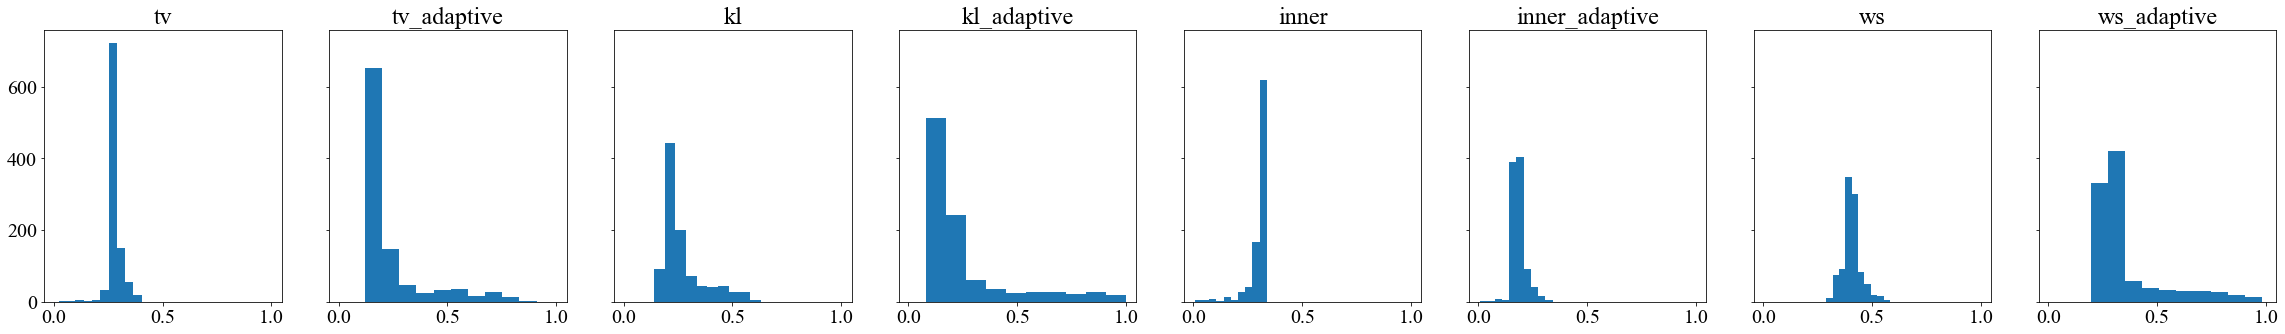

In [25]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, len(list(methods)), sharex=True, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):
    axs[i].hist(EU[m])
    axs[i].set_title(m)

In [26]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(9,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    plt.hist(EU[m], alpha=.75, edgecolor='k', linewidth=2)
    plt.xlabel("EU")
    # plt.title("GT distributions")
    plt.xlim([0,1])
    # os.makedirs(os.path.join("figures", "cifar10h", "uncertainty", "seed_"+exp_seed_str, "epistemic_histograms"), exist_ok=True)  
    # plt.savefig(os.path.join("figures", "cifar10h", "uncertainty", "seed_"+exp_seed_str, "epistemic_histograms", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    # plt.close()

# Vizualization of AU/EU plot

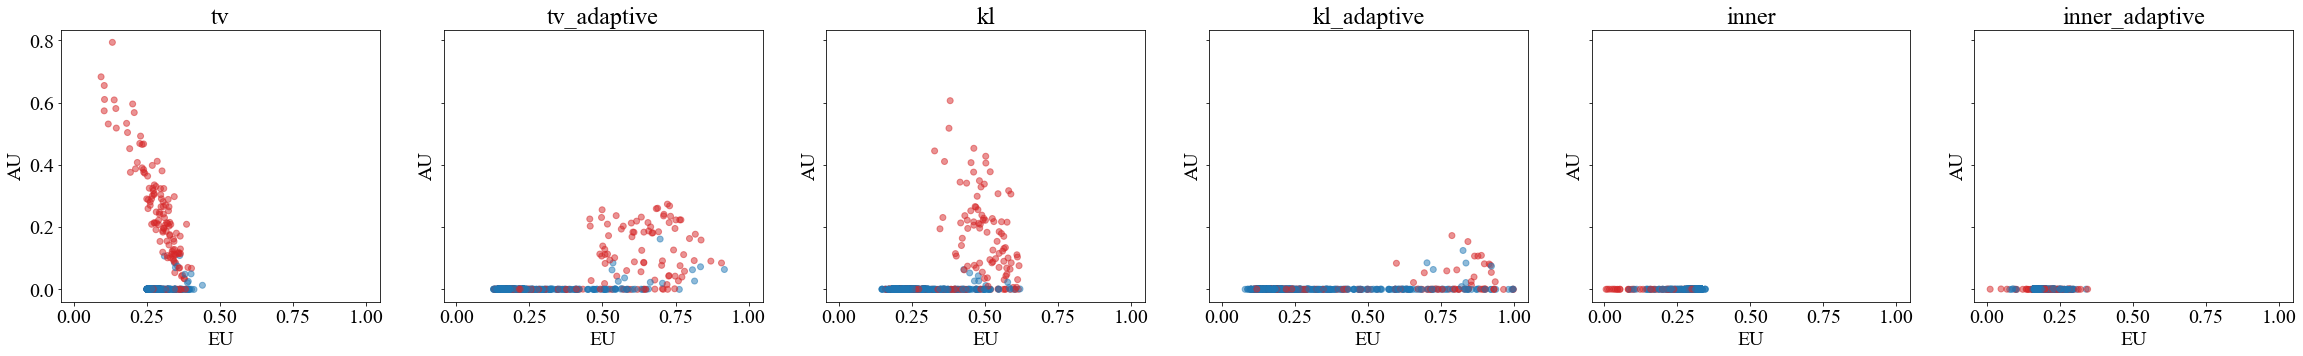

In [57]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=True, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):


    axs[i].scatter(EU[m], np.array(AU[m]), alpha=0.5, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]])
    # axs[i].scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # for jj, j in enumerate([1, 42, 146]):
    #     axs[i].annotate(jj+1, (EU[m][j],AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)


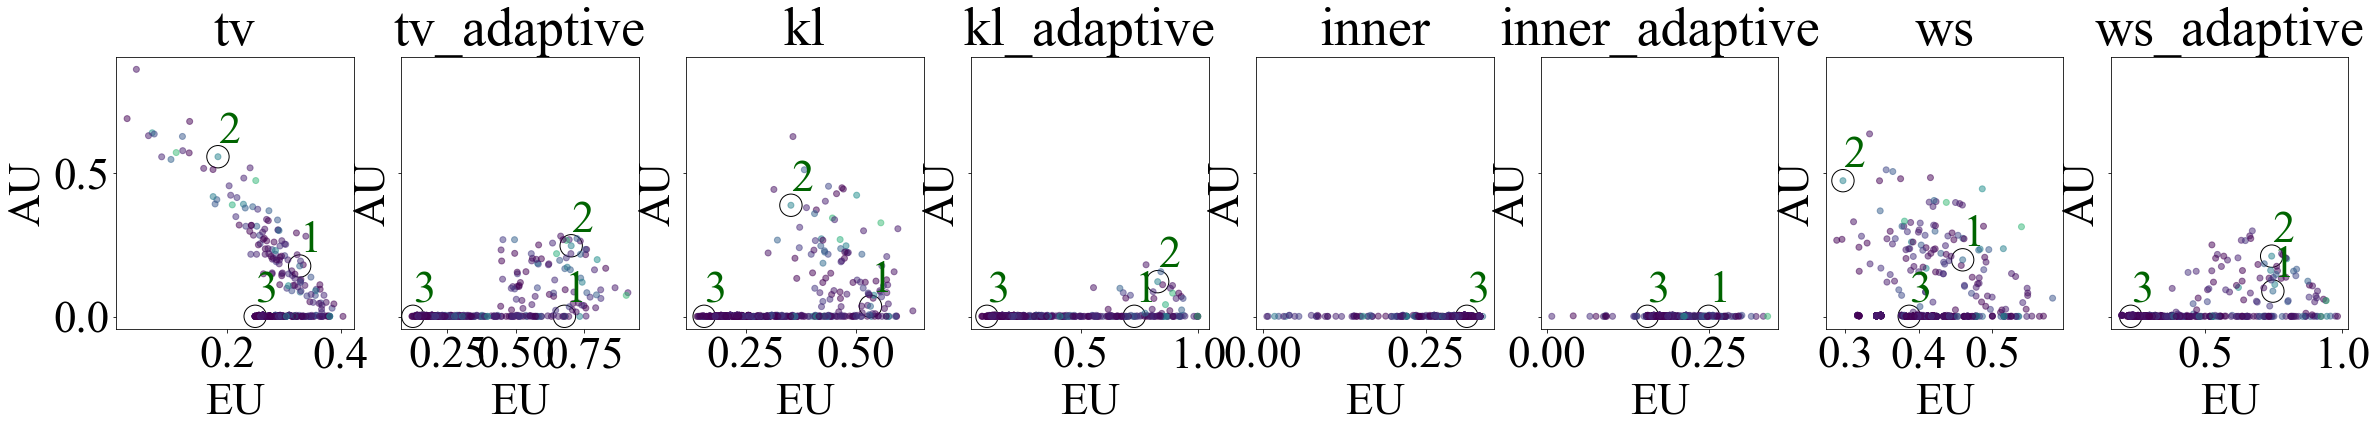

In [27]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(np.array(EU[m]), np.array(AU[m]), alpha=0.5, c=entropy(lambda_test, axis=1, base=10), cmap='viridis', vmax=1, zorder=3)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    for jj, j in enumerate([583, 302, 307]):
        axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)


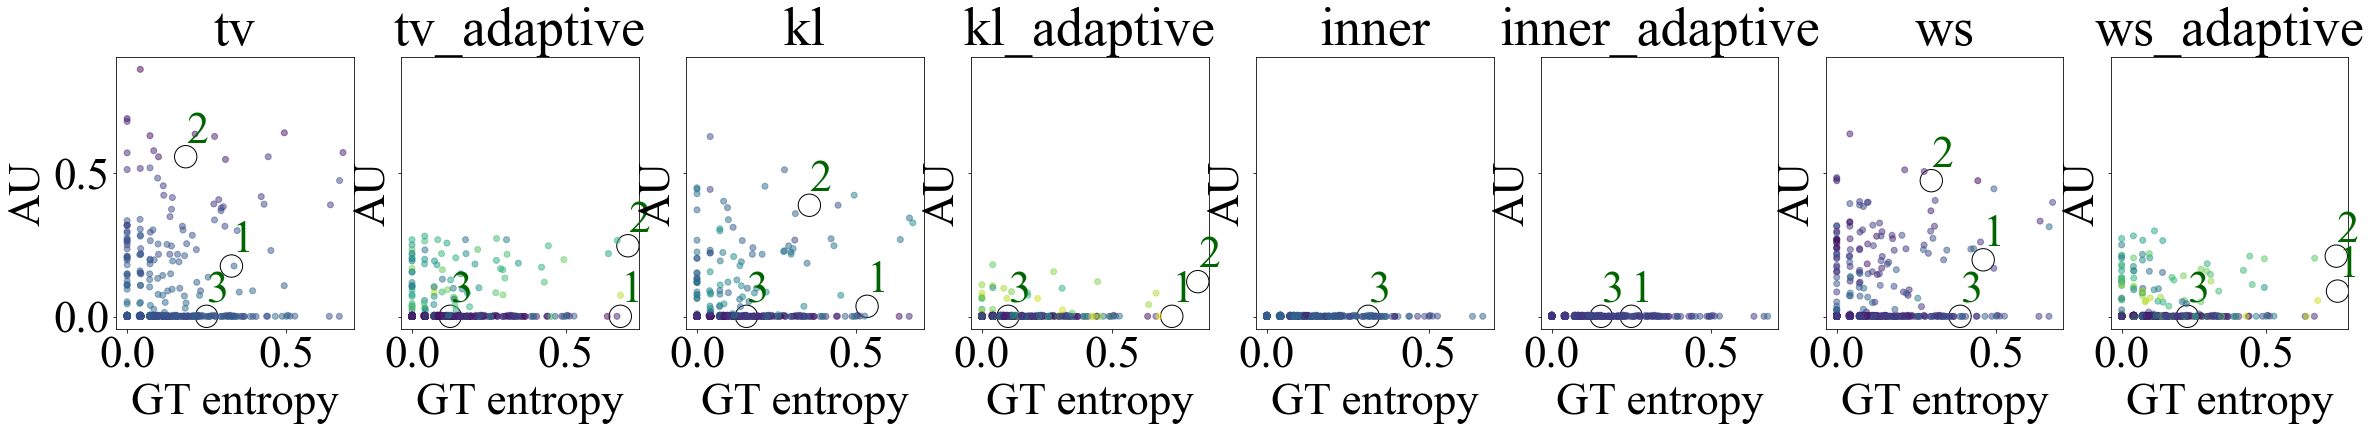

In [76]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(entropy(lambda_test, axis=1, base=10), np.array(AU[m]), alpha=0.5, c=np.array(EU[m]), cmap='viridis', vmax=1, zorder=3)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    for jj, j in enumerate([583, 302, 307]):
        axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("GT entropy")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)

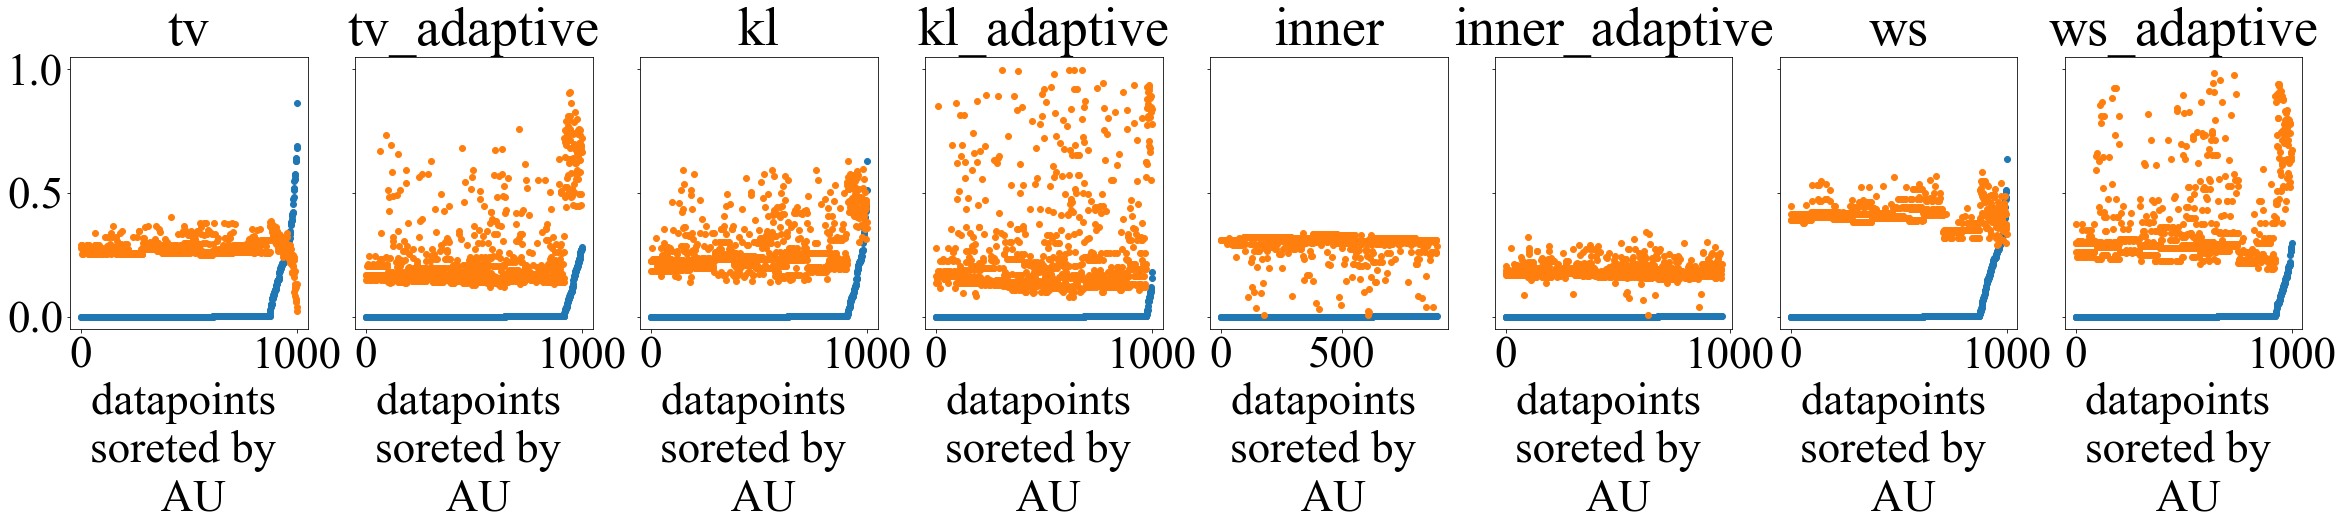

In [75]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(np.arange(len(lambda_test)), np.array(AU[m])[np.argsort(AU[m])], label="AU")
    axs[i].scatter(np.arange(len(lambda_test)), np.array(EU[m])[np.argsort(AU[m])], label="EU")
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    # for jj, j in enumerate([583, 302, 307]):
    #     axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("datapoints \nsoreted by \n AU")
    # axs[i].set_ylabel("AU")
    # axs[i].legend()
    axs[i].set_title(m)


In [69]:
lambda_test[np.array(EU["tv"])<0.3].shape

(865, 10)

In [58]:
entropy(lambda_test, base=10, axis=1)[412]

0.0

In [28]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(7,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    # plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
    sc = plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=entropy(lambda_test, axis=1, base=10), cmap='viridis', vmax=1, s=200, zorder=3)
    # plt.scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['gold']*3, marker="*", s=300,edgecolor='black', linewidth = 0.5)
    sc2 = plt.scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]],  marker="o", s=800,edgecolor='k', linewidth = 1, zorder=3)
    sc2.set_facecolor("none")
    for jj, j in enumerate([583, 302, 307]):
        plt.annotate(jj+1, (EU[m][j]-0.025,0.05+AU[m][j]), c="k")
    plt.xlabel("EU")
    plt.ylabel("AU")
    plt.xticks([0, 0.5, 1])

# Set y-axis tick values
    plt.yticks([0, 0.5, 1])
    plt.xlim([0,1])
    plt.ylim([-.10,1])
    # os.makedirs(os.path.join("figures", "cifar10h", "uncertainty", "seed_"+exp_seed_str, "AU_EU"), exist_ok=True)  
    # plt.savefig(os.path.join("figures", "cifar10h", "uncertainty", "seed_"+exp_seed_str, "AU_EU", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    # plt.close()

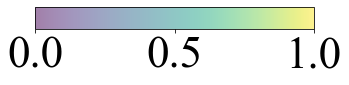

: 

In [150]:
plt.figure(figsize=(5, 0.4))
ax = plt.subplot()
scbar = plt.colorbar(sc, ax, orientation="horizontal")
# plt.savefig(os.path.join("figures", "cifar10h", "uncertainty", "seed_"+exp_seed_str, "AU_EU", "colormap_horizontal.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

# Vizualization of AU/Entropy(lambda) plots given differen methods

# Vizualization of epistemic uncertainty hsitogram given differen methods

# Vizualization of AU/EU plots given differen methods

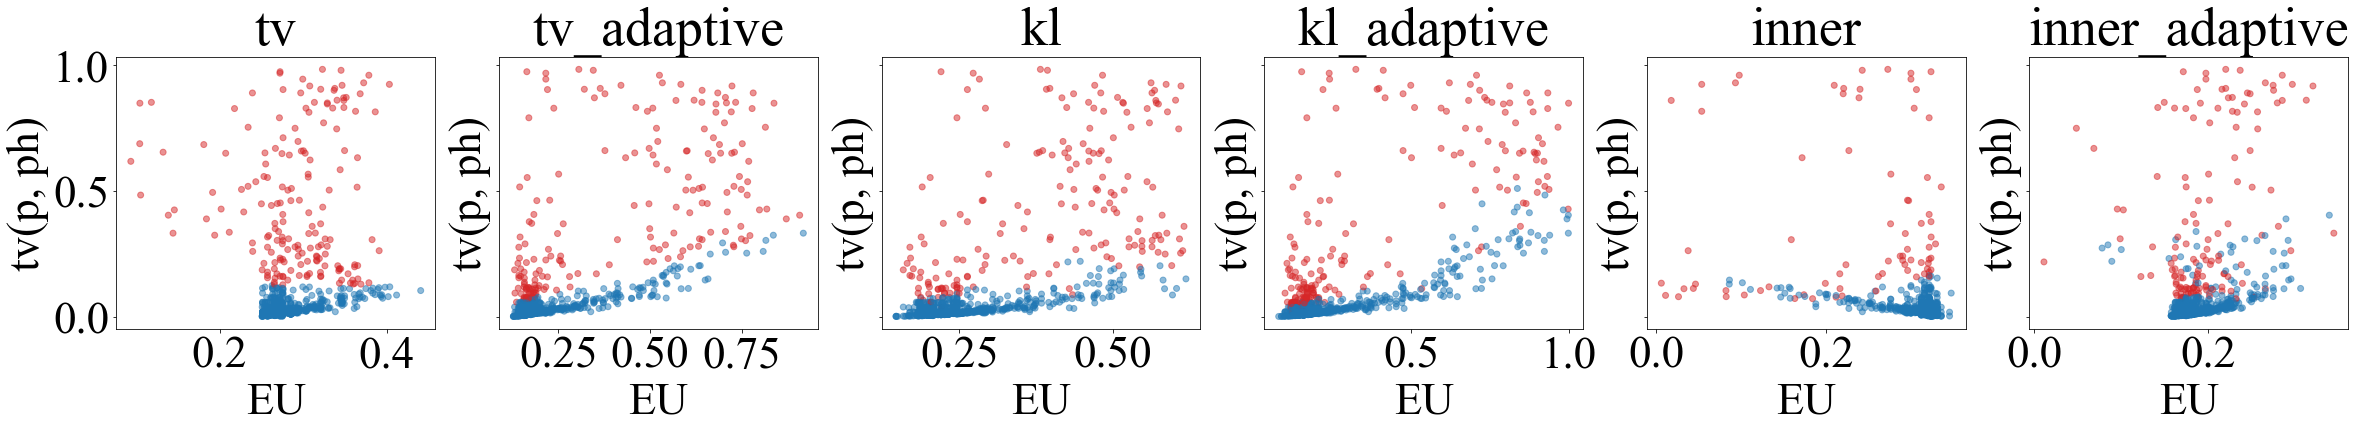

In [93]:
fig, axs = plt.subplots(1, len(list(methods)), sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):


    axs[i].scatter(EU[m], (0.5*np.sum(np.abs(lambda_hat_test-lambda_test), axis=1)), alpha=0.5, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]])
    # axs[i].scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # for jj, j in enumerate([1, 42, 146]):
    #     axs[i].annotate(jj+1, (EU[m][j],AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("tv(p, ph)")
    axs[i].set_title(m)

# Vizualization of AU/Entropy(lambda) plots given differen methods

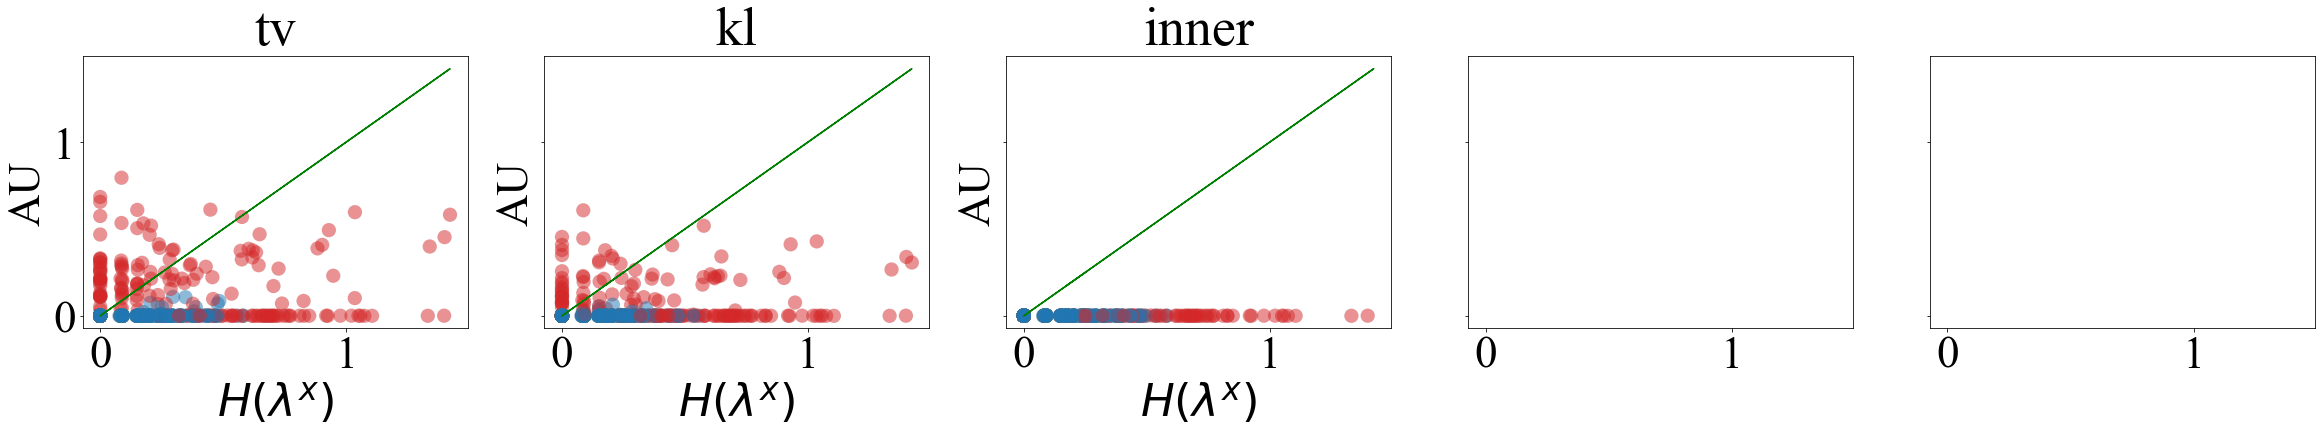

In [94]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==1:
            axs[i].scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
            axs[i].plot(entropy(lambda_test, axis=1, base=3), entropy(lambda_test, axis=1, base=3), c="green")
            axs[i].set_xlabel(r'$H(\lambda^x)$')
            axs[i].set_ylabel("AU")
            axs[i].set_title(m)
            i = i + 1

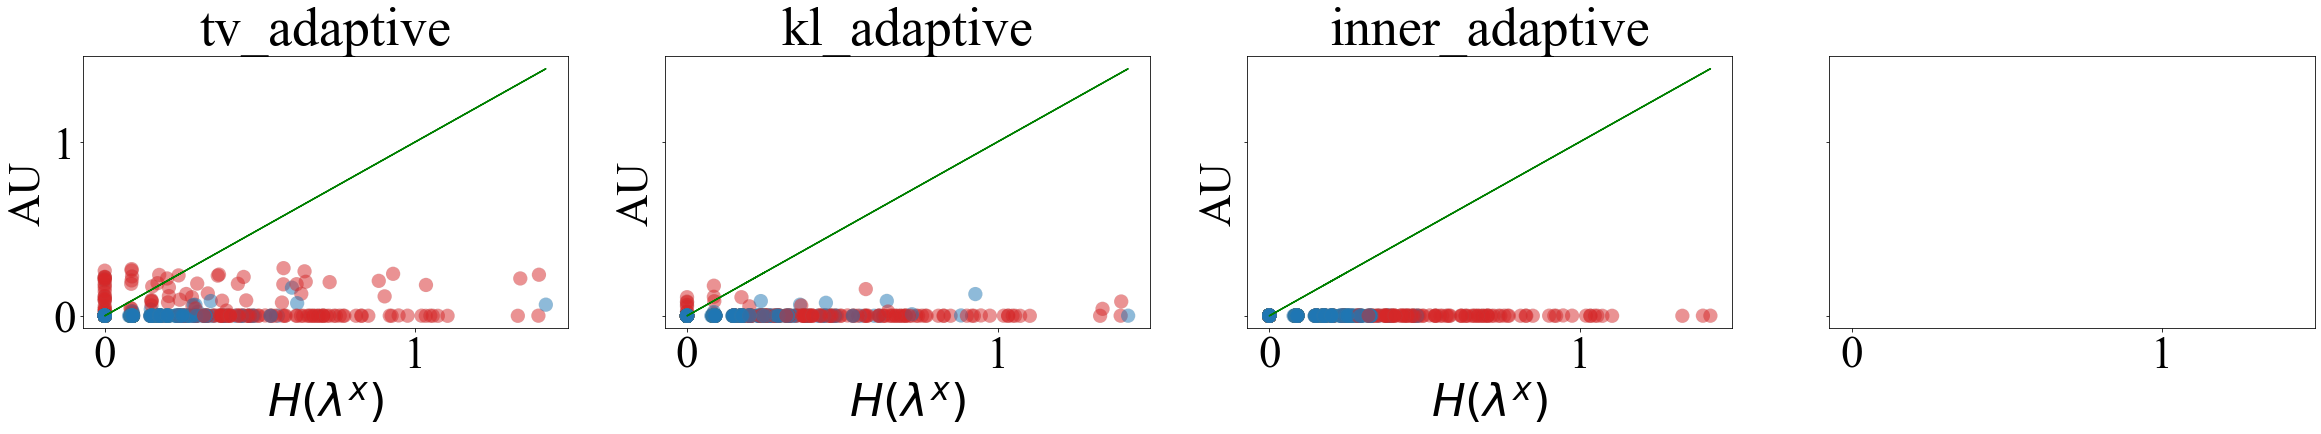

In [95]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==2:
            axs[i].scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
            axs[i].plot(entropy(lambda_test, axis=1, base=3), entropy(lambda_test, axis=1, base=3), c="green")
            axs[i].set_xlabel(r'$H(\lambda^x)$')
            axs[i].set_ylabel("AU")
            axs[i].set_title(m)
            i = i + 1

In [ ]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(7,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    plt.scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)

    plt.xlabel(r'$H(\lambda^x)$')
    plt.ylabel("AU")
    plt.xticks([0, 0.5, 1])

# Set y-axis tick values
    plt.yticks([0, 0.5, 1])
    plt.xlim([0,1])
    plt.ylim([-.10,1])
    # os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_entropy_test"), exist_ok=True)  
    # plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_entropy_test", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    # plt.close()

# Vizualization of scores vs entropy of the predicted distributions, showing why our adaptive method should make sense

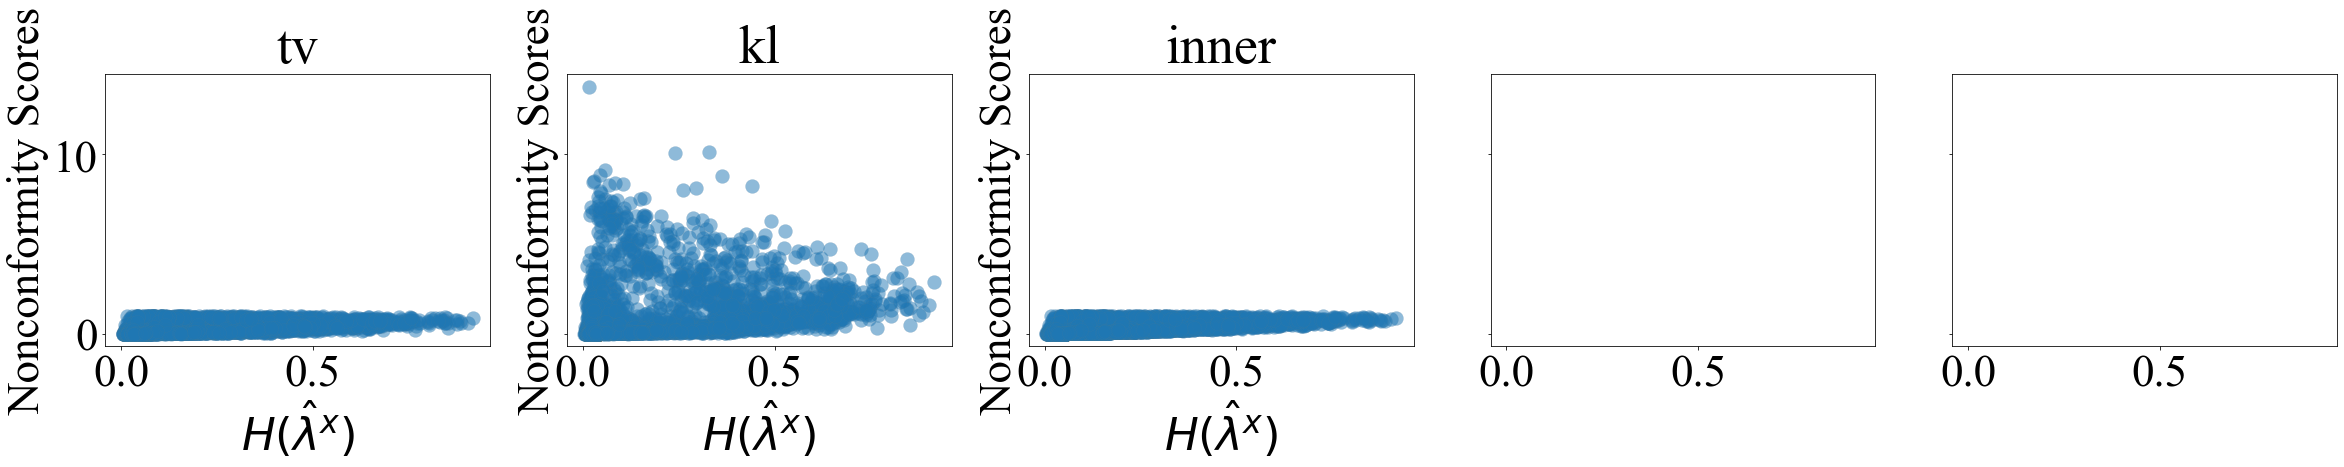

In [97]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==1:
            axs[i].scatter(entropy(lambda_hat_calib, axis=1, base=10), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
            axs[i].set_xlabel(r'$H(\hat{\lambda}^x)$')
            axs[i].set_ylabel("Nonconformity Scores")
            axs[i].set_title(m)
            i = i + 1

In [ ]:
for i, m in enumerate(list(methods)):
    if len(m.split('_'))==1:
        fig = plt.figure(figsize=(7,7)) 
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 30
        plt.scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
        plt.xlabel("$H(\hat{\lambda}^x)$")
        plt.ylabel("Nonconformity Scores")
        plt.xlim([0,1])
        # plt.ylim([-.10,1])
        # os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib"), exist_ok=True)  
        # plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        # plt.close()

# Vizualization of adaptive scores vs entropy of the predicted distributions, showing that our method works

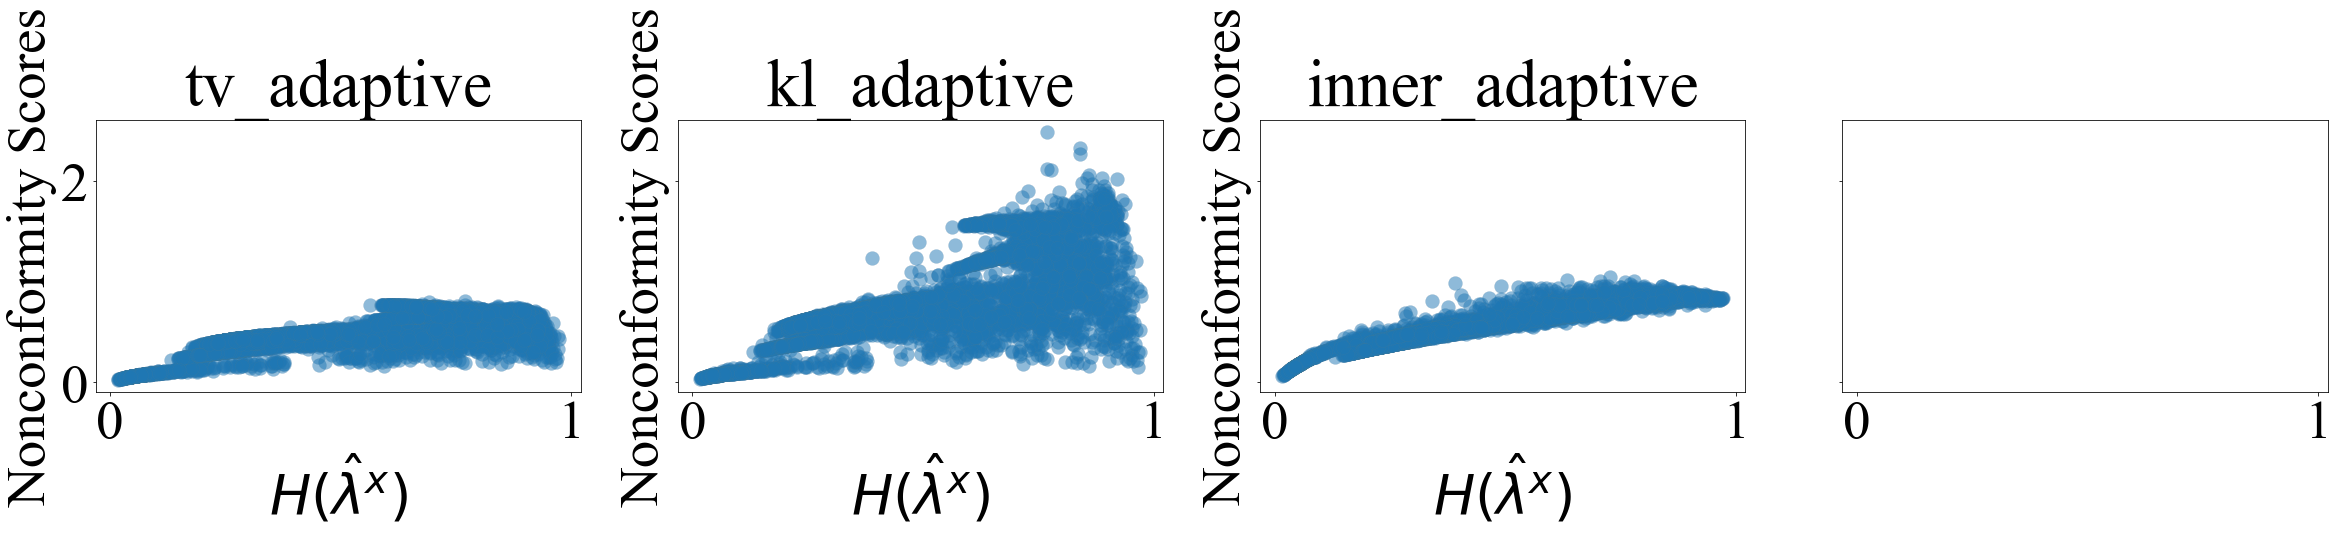

In [650]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==2:
            axs[i].scatter(entropy(lambda_hat_calib, axis=1, base=10), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
            axs[i].set_xlabel(r'$H(\hat{\lambda}^x)$')
            axs[i].set_ylabel("Nonconformity Scores")
            axs[i].set_title(m)
            i = i + 1

In [106]:
for i, m in enumerate(list(methods)):
    if len(m.split('_'))==2:
        fig = plt.figure(figsize=(7,7)) 
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 30
        plt.scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
        plt.xlabel("$H(\hat{\lambda}^x)$")
        plt.ylabel("Nonconformity Scores")
        plt.xlim([0,1])
        # plt.ylim([-.10,1])
        # os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib"), exist_ok=True)  
        # plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        # plt.close()

# Finding interesting examples to show in the paper

In [179]:
np.where((np.array(EU["kl"])>0.6) & (entropy(lambda_test, axis=1, base=10)>0.3) )

(array([583], dtype=int64),)

In [98]:
np.where((np.array(EU["tv"])>0.4) & (entropy(lambda_test, axis=1, base=10)> 0.2) )

(array([440, 507], dtype=int64),)

In [59]:
np.where((np.array(EU["tv"])<0.25) & (entropy(lambda_test, axis=1, base=10)<0.01) & (np.array(AU["tv"])<0.1))

(array([375, 405, 743, 918], dtype=int64),)

In [464]:
np.where((np.array(EU["kl"])>0.6) & (entropy(lambda_test, axis=1, base=10)<0.01))

(array([  74,  197,  991, 1221, 2060, 2604, 2689, 2806, 3221, 4311],
       dtype=int64),)

In [480]:
np.where((np.array(EU["kl"])<0.45) & (entropy(lambda_test, axis=1, base=10)>0.4) & (np.array(AU["kl"])>0.4))

(array([4072, 4280], dtype=int64),)

In [614]:
np.where((np.array(EU["kl"])>0.6) & (entropy(lambda_test, axis=1, base=10)>0.5))

(array([852, 927], dtype=int64),)

In [656]:
np.where((np.array(EU["kl"])>0.5) & (entropy(lambda_test, lambda_hat_test, axis=1, base=2)>0.75))

(array([  8, 197, 370, 540, 555, 871], dtype=int64),)

In [404]:
np.where((np.array(EU["tv_adaptive"])>0.15) &  (cvg["tv_adaptive"]))

(array([4913], dtype=int64),)

In [144]:
np.argmin(EU["kl"])

918

In [373]:
EU["kl"][idx]

0.12704814607149498

In [77]:
k = 197

In [78]:
m = "kl"

In [79]:
cvg["tv"][k]

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


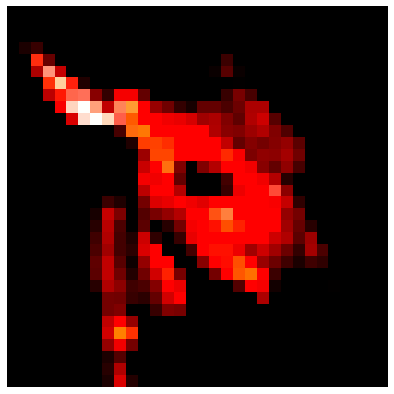

In [80]:
plot_cifar_img(images_test[k])
os.makedirs(os.path.join("figures", "cifar10h", "seed_"+exp_seed_str+"_k_"+str(k)), exist_ok=True)  
plt.savefig(os.path.join("figures", "cifar10h", "seed_"+exp_seed_str+"_k_"+str(k), "image.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

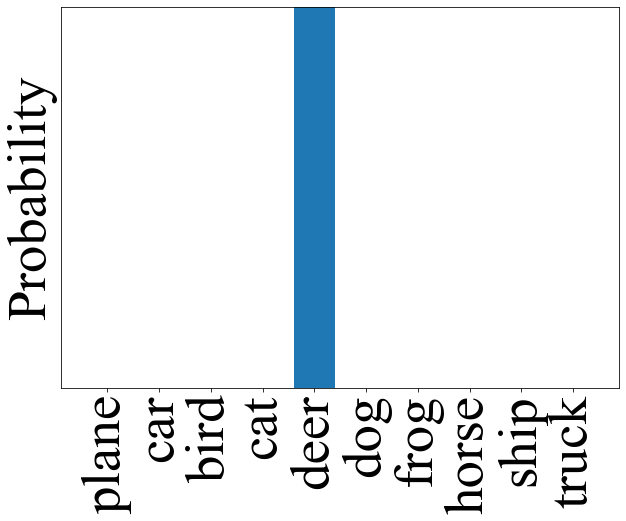

In [82]:
plot_cifar_dist(lambda_test[k])
plt.savefig(os.path.join("figures", "cifar10h", "seed_"+exp_seed_str+"_k_"+str(k), "lambda.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

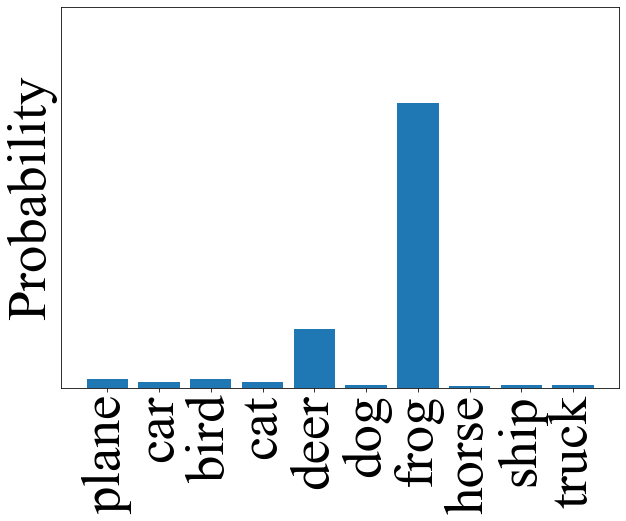

In [83]:
plot_cifar_dist(lambda_hat_test[k])
plt.savefig(os.path.join("figures", "cifar10h", "seed_"+exp_seed_str+"_k_"+str(k), "lambda_hat.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

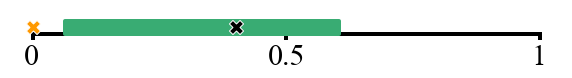

In [84]:
plot_interval(AU["kl"][k], TU["kl"][k], entropy(lambda_test[k], base=10), entropy(lambda_hat_test[k], base=10))
plt.savefig(os.path.join("figures", "cifar10h", "seed_"+exp_seed_str+"_k_"+str(k), m+"_unc_interval.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

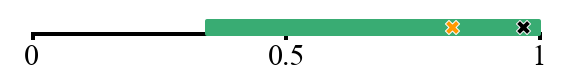

In [680]:
plot_interval(AU["kl_adaptive"][idx], TU["kl_adaptive"][idx], entropy(lambda_test[idx], base=10), entropy(lambda_hat_test[idx], base=10))

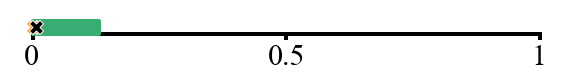

In [67]:
plot_interval(AU["tv_adaptive"][k], TU["tv_adaptive"][k], entropy(lambda_test[k], base=10), entropy(lambda_hat_test[k], base=10))

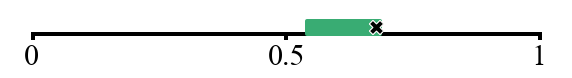

In [532]:
plot_interval(AU["tv"][idx], TU["tv"][idx], entropy(lambda_test[idx], base=10), entropy(lambda_hat_test[idx], base=10))

This is the optimization function that finds distributions with higest and lowest entropy within a certain constraint

In [230]:
from scipy.optimize import minimize
def entropy_max_min(p, epsilon, method="kl", mode=None):
    n = 10

    def neg_entropy(q):
        return -entropy(q, base=len(q))

    def pos_entropy(q):
        return entropy(q, base=len(q))
    
    # Define constraint function based on method
    if method == 'kl':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - entropy(p, q, base=2)
    elif method == 'tv':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - h.tv(p,q)
    elif method == 'inner':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - (1-np.inner(p,q))
    elif method == 'ws':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - wasserstein_distance(np.arange(10), np.arange(10), p, q)
    elif method == 'so':
        # Initial guess for q
        q0 = p.mean().numpy()
        mode_prob = p.prob(mode).numpy()
        def constraint_func(q):
            q_prob = p.prob(q).numpy()
            return epsilon - (1-q_prob/mode_prob)
    
    # Constraint: sum of probabilities must be 1
    def sum_constraint(q):
        return np.sum(q) - 1
    
    
    
    # Define bounds for q: probabilities must be between 0 and 1
    bounds = [(0, 1)] * n
    
    # Define sum constraint
    sum_cons = {'type': 'eq', 'fun': sum_constraint}
    
    # Optimization for maximizer
    result_max = minimize(neg_entropy, q0, method='SLSQP', bounds=bounds, constraints=[{'type': 'ineq', 'fun': constraint_func}, sum_cons])
    
    # Extract the optimal distribution q for maximizer
    q_max = result_max.x
    
    q1 = np.zeros_like(q0)
    q1[np.argmax(p)] = 1
    # Optimization for minimizer
    result_min = minimize(pos_entropy, q0, method='SLSQP', bounds=bounds, constraints=[{'type': 'ineq', 'fun': constraint_func}, sum_cons])
    
    # Extract the optimal distribution q for minimizer
    q_min = result_min.x
    
    return q_max, q_min

In [244]:
lower_ent = {m: [] for m in ["tv", "tv_ad", "kl", "kl_ad"]}
upper_ent = {m: [] for m in ["tv", "tv_ad", "kl", "kl_ad"]}
for i, p in enumerate(lambda_hat_test):
    for m in ["kl"]:
        if len(m) == 2:
            ents = entropy(entropy_max_min(p, q[m], method=m), base=10, axis=1)
        else: 
            ents = entropy(entropy_max_min(p, q[(m, 0.2)]*entropy(p, base=10), method=m[:2]), base=10, axis=1)

        lower_ent[m].append(ents[1])
        upper_ent[m].append(ents[0])

(array([0.07050741, 0.04376445, 0.0579618 , 0.20157072, 0.18496067,
       0.07217366, 0.04965154, 0.21751793, 0.0469042 , 0.05498763]), array([7.82385454e-04, 1.92438684e-05, 1.97116036e-05, 8.11988782e-01,
       1.66772770e-04, 9.53272599e-07, 2.00385953e-06, 1.87961058e-01,
       2.57344564e-05, 1.93177415e-05]))


In [247]:
methods = list(calib_scores.keys())
AU = {m: [] for m in methods}
TU = {m: [] for m in methods}
EU = {m: [] for m in methods}
for i,p in enumerate(lambda_hat_test):
    for m in ["tv", "tv_adaptive"]:
        if m[-8:] == 'adaptive':
            ents = entropy(entropy_max_min(p, q[m]*(entropy(p, base=10)+hyper), method=m.split('_')[0]), base=10, axis=1)
        else:
            ents = entropy(entropy_max_min(p, q[m], method=m), base=10, axis=1)
        AU[m].append(ents[1])
        TU[m].append(ents[0])
        EU[m].append(ents[0] - ents[1])

0.3184409358927929

In [248]:
entropy([0.07050741, 0.04376445, 0.0579618 , 0.20157072, 0.18496067, 0.07217366, 0.04965154, 0.21751793, 0.0469042 , 0.05498763], lambda_hat_test[86], base=2) < q["kl"]

0.536152299507207

In [249]:
entropy([7.82385454e-04, 1.92438684e-05, 1.97116036e-05, 8.11988782e-01, 1.66772770e-04, 9.53272599e-07, 2.00385953e-06, 1.87961058e-01, 2.57344564e-05, 1.93177415e-05], lambda_hat_test[86], base=2) < q["kl"]

1.0190410847063598

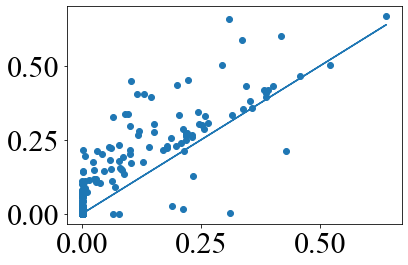

In [239]:
plt.scatter(AU[m], lower_ent[m])
plt.plot(AU[m], AU[m])

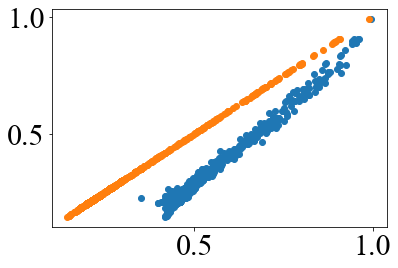

In [237]:
plt.scatter(upper_ent[m], TU[m])
plt.scatter(TU[m], TU[m])

In [242]:
np.where((np.array(AU[m])>0.4) & (np.array(lower_ent[m])<0.24))

(array([86], dtype=int64),)